FINAL PROJECT - MIDTERM (PROTOTYPE FEATURE)

In this first part of my project, I am going to show how I implemented a model to predict if 
a skin lesion is benign or malignant. This is based on kaggle.com dataset named "Skin Cancer: Malignant vs. Benign".
If you would like to understand more about the algorithm and the dataset itself, please refer to my report.

In [17]:
#Importing libraries

#native
import os
import warnings

#non-native
#PIL - Python Image Library (pillow)
from PIL import Image 
#Numpy - Numeric Python Library
import numpy as np
#Pandas - Data manipulation
import pandas as pd
#Matplotlib - Data Visualisation
import matplotlib.pyplot as plt

#Sci-Kit Learn - Machine Learning Library
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#TensorFlow - AI & Machine Learning
import tensorflow as tf
# from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3

import keras
from keras import layers

warnings.filterwarnings("ignore")

First thing is to build dataframee from the dataset so I can manipulate it. One function to handle train dataframe/dataset and one function to handle test dataframe/dataset.

In [6]:
#checking where the dataset is located in the operating system. I will use this info as parameters for the next functions.

my_dir_train = os.path.join(os.getcwd(),'DATASET/kaggle_skin_cancer_dataset/train')
my_dir_test = os.path.join(os.getcwd(),'DATASET/kaggle_skin_cancer_dataset/test')

print(my_dir_train)
print(my_dir_test)

/Users/mychelantonacio/Dropbox/Pessoal/Documentos digitalizados/UK/University of London/Level 6/2_Final Project/FINALTERM/fp_final_project_full/DATASET/kaggle_skin_cancer_dataset/train
/Users/mychelantonacio/Dropbox/Pessoal/Documentos digitalizados/UK/University of London/Level 6/2_Final Project/FINALTERM/fp_final_project_full/DATASET/kaggle_skin_cancer_dataset/test


In [7]:
#reading the train folder to collect images paths and its classes (malignant or benign).
def get_train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)

    for file in files:
        if file != ".DS_Store":
            label_dir = os.path.join(tr_path, file)
            label = os.listdir(label_dir)
            for image in label:
                image_path = os.path.join(label_dir, image)
                class_paths.append(image_path)
                classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)

    return tr_df

In [8]:
#reading the test folder to collect images paths and its classes (malignant or benign).
def get_test_df(test_path):
    classes = []
    class_paths = []
    files = os.listdir(test_path)
    for file in files:
        if file != ".DS_Store":
            label_dir = os.path.join(test_path, file)
            label = os.listdir(label_dir)
            for image in label:
                image_path = os.path.join(label_dir, image)
                class_paths.append(image_path)
                classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

Now that I have defined how to collect my data into datasets, I can use it.

In [9]:
train_df = get_train_df(my_dir_train)
test_df = get_test_df(my_dir_test)

In [10]:
#Split into valid (validation) and test sets (I am using train set as half to keep it equally balanced betwwen test and validation)
valid_df, test_df = train_test_split(test_df,  train_size=0.5, shuffle=True, random_state=20)

Now it's time to preprocess the data we have loaded into dataframes. For this part I am using Keras (inside Tensorflow lib) to create an image generator.

In [11]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (224, 224, 3)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='Class Path', y_col='Class', target_size=img_size, color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', target_size=img_size, color_mode= 'rgb', shuffle=True, batch_size=batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='Class Path', y_col='Class', target_size=img_size, color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


Let's check some of the images we've just preprocessed using matplotlib.

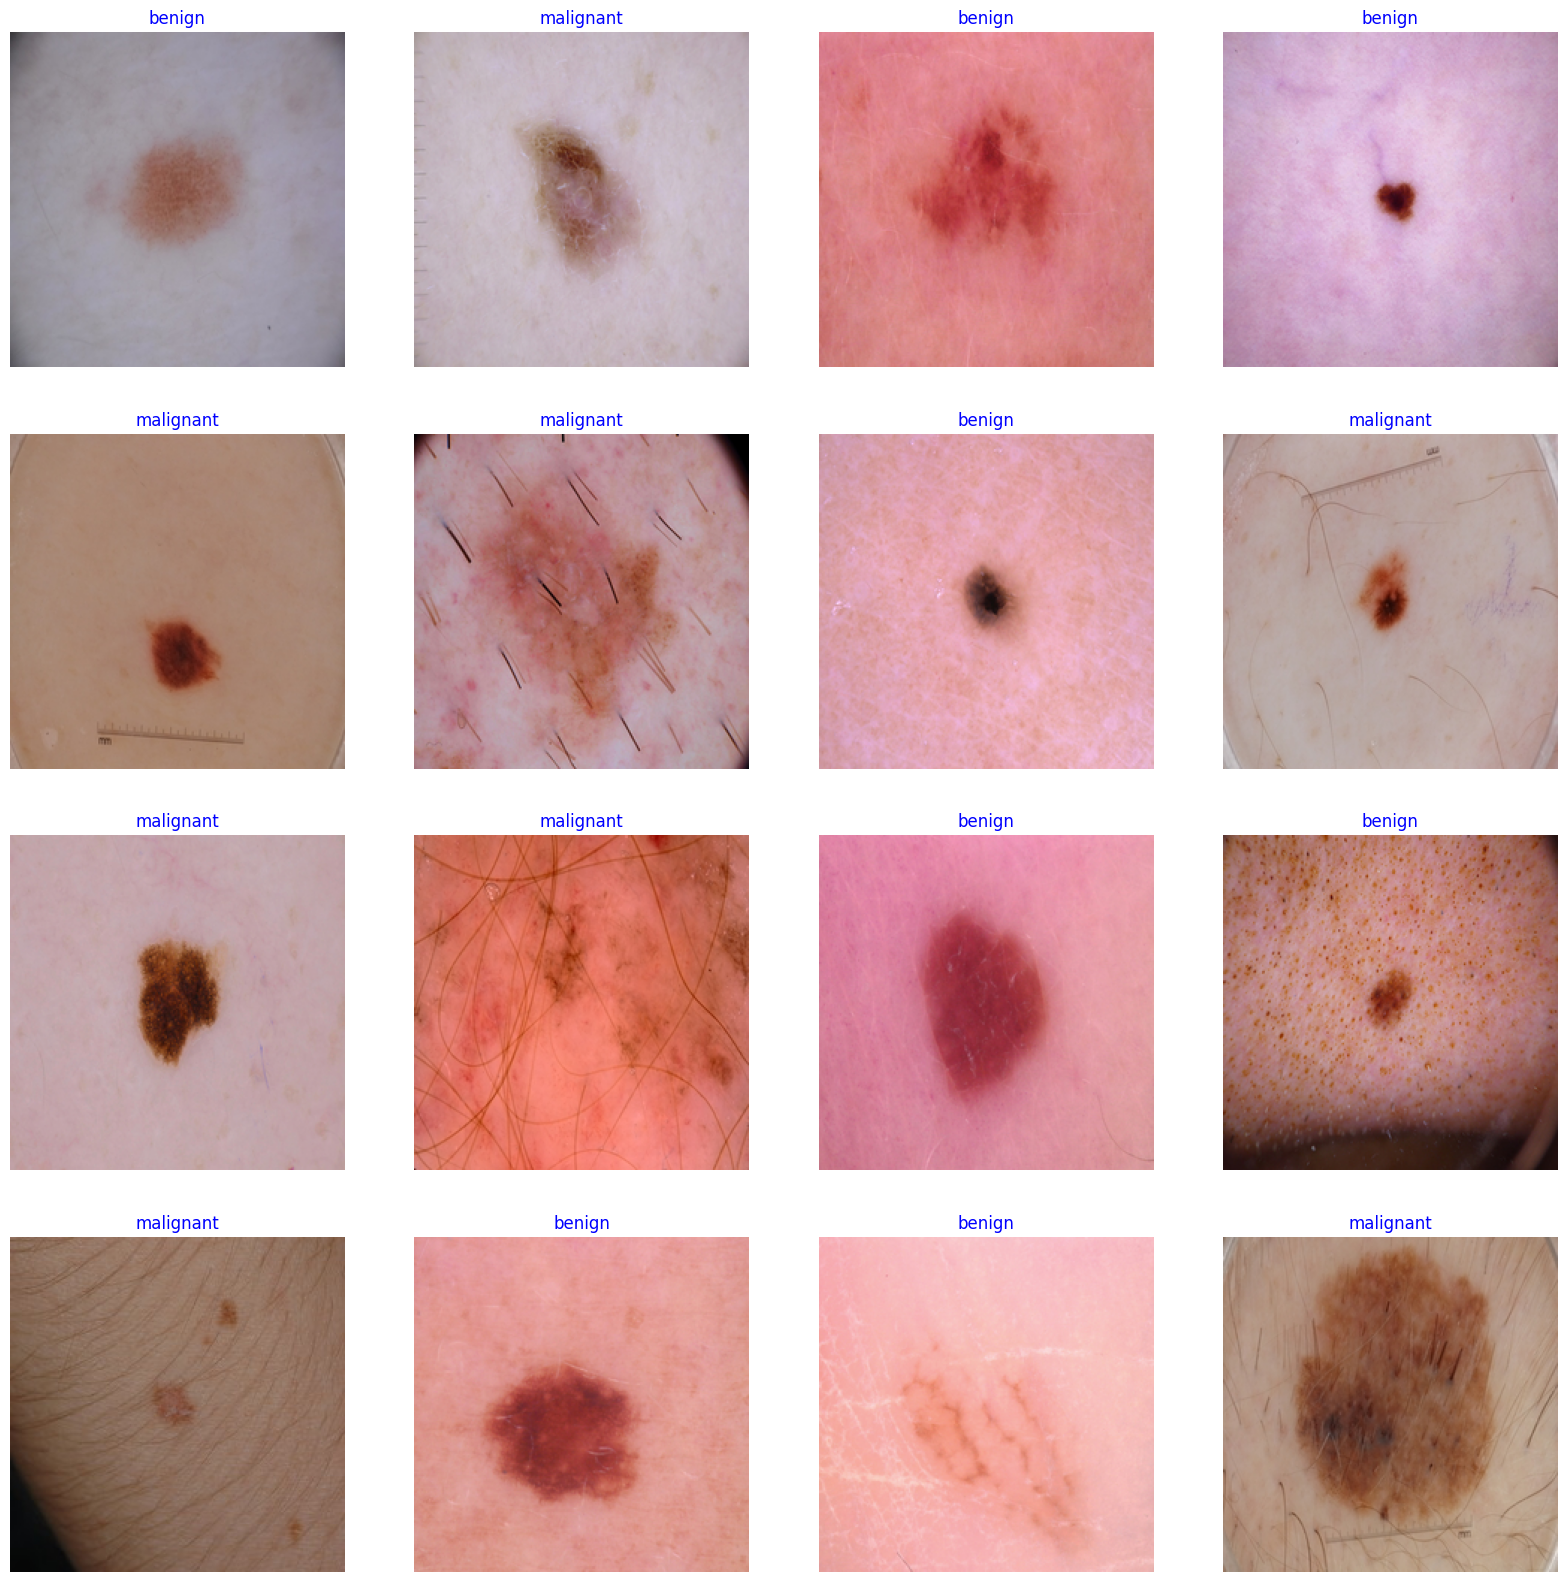

In [12]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen) 

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

As we can see above, the images have been preprocessed as expected and now we can see they are high quality to build the model further. To build the model based on those images, I am using Keras/Tensorflow again to pull the algorithms called EfficientNet-B3 which is one of the CNN (Convolutional Neural Networking) algorithms.

In [18]:
# this part of my architecture I described it in detail on my report at section "Implementation"
base_model = EfficientNetB3(include_top=False, weights="imagenet",
                            input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.40, seed=20),
    layers.Dense(2, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

With activations relu and softmax with dropout rate of 40%, we have total of functional params of 10783535. Now I will fit the model through epochs (I am testing how many times is best yet).

In [ ]:
import pickle
epochs = 10

history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, 
                    validation_steps=None)


In [ ]:
# packaging trained model
import pickle

pickle.dump(model, open('model.pkl','wb'))

After running fit model, we can check it with some tests and validation

In [34]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('----------------------------------')
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('----------------------------------')
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

21/21 [==============================] - 5s 235ms/step - loss: 0.2671 - accuracy: 0.9212
Train Loss:  0.0067862472496926785
Train Accuracy:  0.997724711894989
----------------------------------
Validation Loss:  0.5353586077690125
Validation Accuracy:  0.8666666746139526
----------------------------------
Test Loss:  0.2671459913253784
Test Accuracy:  0.9212121367454529


As I am using ACCURACY as my permance parameter, we can see I got
Train Accuracy - 99% (approximately)
Validation Accuracy - 87% (approximately)
Test Accuracy - 91% (approximately)

This is a very good score as based on the literature review, human specialists achive less than this. Therefore, we can say this model performs better than any human in the world.

Going further exploring the results, let's check PRECISION, RECALL, F1-SCORE, and SUPPORT.

In [35]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      benign       0.92      0.95      0.93       190
   malignant       0.93      0.89      0.91       140

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



This concludes the model building phase where I collected the kaggle skin cancer dataset, loaded it, split it (test, validation, training), built the model and checked the results with accuracy and other metrics above.